In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys

import torch
import torchio as tio
from ipywidgets import interact
import matplotlib.pyplot as plt

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
from segmentation_pipeline import *

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [2]:
from research.dmri_hippo.configs.main_config import get_context

variables = dict(DATASET_PATH="X:/Datasets/Diffusion_MRI_cropped/", CHECKPOINTS_PATH="X:/Checkpoints/")
context = get_context(device, variables)
context.init_components()

In [ ]:
iteration = 400
file_path = f"X:\\Checkpoints\\Diffusion_MRI\\dmri-hippo-seg-debugging\\dmri-hippo-cycle-flash-1q798mvn\\best_checkpoints\\iter{iteration:08}.pt"
variables = dict(DATASET_PATH="X:/Datasets/Diffusion_MRI/", CHECKPOINTS_PATH="X:/Checkpoints/")
context = TorchContext(device, file_path=file_path, variables=variables)
context.init_components()

In [ ]:
iteration = 118
file_path = f"X:\\Checkpoints\\MSSEG2\\msseg2-hooks-capacitor-2oachxos\\iter{iteration:08}.pt"
variables = dict(DATASET_PATH="X:/Datasets/MSSEG2_resampled/")

device = torch.device('cpu')
context = TorchContext(device, file_path=file_path, variables=variables)
context.init_components()

In [ ]:
config = load_module("./configs/msseg2.py")

variables = dict(DATASET_PATH="X:/Datasets/MSSEG2_processed/")
context = config.get_context(device, variables)
context.init_components()

In [5]:
dataset = context.dataset
all_subject_names = list(dataset.all_subjects_map.keys())

noise = tio.RandomNoise(std=0.035, p=0.3)
blur = tio.RandomBlur((0, 1), p=0.2)
augmentations = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2)),
    tio.RandomElasticDeformation(p=0.5, num_control_points=(7, 7, 4), locked_borders=1, image_interpolation='bspline'),
    tio.RandomBiasField(p=0.5),
    tio.RescaleIntensity((0, 1), (0.01, 99.9)),
    tio.RandomGamma(p=0.8),
    tio.RescaleIntensity((-1, 1)),
    tio.OneOf([
        tio.Compose([blur, noise]),
        tio.Compose([noise, blur]),
    ])
])
augmentations = ReconstructMeanDWI(num_dwis=(1, 7), num_directions=(1, 3), directionality=(4, 10))

custom_transform = tio.Compose([
    tio.CropOrPad((96, 88, 24), padding_mode='edge', mask_name='whole_roi_union'),
    MergeLabels([('left_whole', 'right_whole')], right_masking_method="Right", include="whole_roi"),
    augmentations,
    tio.RescaleIntensity((-1., 1.), (0.5, 99.5)),
    ConcatenateImages(image_names=["mean_dwi", "md", "fa"], image_channels=[1, 1, 1], new_image_name="X"),
    RenameProperty(old_name="whole_roi", new_name="y"),
    CustomOneHot(include="y")
])
#custom_transform = context.dataset.transforms['training']

@interact(name=all_subject_names, 
          mode=['vis_subject', 'model_contour', 'vis_model'],
          randomize=False)
def vis(name, mode, randomize):
    context.model.eval()
    
    def get_subject():
        if custom_transform is None:
            subject = context.dataset[name]
        else:
            subject = context.dataset.all_subjects_map[name]
            subject = copy.deepcopy(subject)
            subject = custom_transform(subject)
        return subject
    
    
    if mode == 'vis_subject':
        
        #augmentation = tio.RandomAffine(scales=0.2, degrees=45)
        #augmentation = tio.RandomElasticDeformation()
        #subject = augmentation(subject)
        
        vis_subject(context, [get_subject() for i in range(4)])
    
    elif mode == 'model_contour':
        #subject = tio.CropOrPad((96, 96, 96))(subject)
        subject = tio.EnsureShapeMultiple(32)(subject)
        
        X = subject['X']['data'][None].to(device)
        with torch.no_grad():
            y_pred = context.model(X)[0]
            y_pred = y_pred > 0.5
        subject['y_pred'] = copy.deepcopy(subject['y'])
        subject['y_pred'].set_data(y_pred)
            
        vis_subject(context, subject)
   
    elif mode == 'vis_model':
        subject = tio.CropOrPad((96, 96, 96))(subject)
        vis_model(context, subject)

interactive(children=(Dropdown(description='name', options=('ab300_001', 'ab300_002', 'ab300_003', 'ab300_004'…

In [ ]:
for subject in context.dataset:
    time01 = subject['flair_time01'].data
    time01 = subject['flair_time01'].data
    print(subject['name'], subject['flair_time01'], time01.mean(), time01.std(), time01.min(), time01.max())

In [ ]:
for subject in context.dataset:
    print(subject['name'], subject['flair_time01'])

In [ ]:
subject = context.dataset[0]

In [ ]:
import numpy as np

mask = subject['hbt_roi'].data.bool()[0]
W, H, D = mask.shape
W_where, H_where, D_where = torch.where(mask)

slice_ids, counts = torch.unique(W_where, return_counts=True)
interesting_slice_ids_ids = torch.argsort(counts, descending=True)
interesting_slice_ids = slice_ids[interesting_slice_ids_ids]

print(interesting_slice_ids)


In [ ]:
subject = FindInterestingSlice()(subject)


In [ ]:
subject['y']['interesting_slice_ids']

In [ ]:
x = torch.ones(1)
x.dtype == torch.float

In [ ]:
from random import Random

fold_ids = [i % 5 for i in range(42)]
Random(0).shuffle(fold_ids)
fold_ids

In [ ]:
dataset

In [ ]:
import numpy as np

x = torch.ones(3, 5, 7)

perm = (1, 2, 0)
x = x.permute(perm)

inverse_perm = tuple(torch.argsort(torch.tensor(perm)).tolist())
print(inverse_perm)
x = x.permute(inverse_perm)

print(x.shape)

In [ ]:
from itertools import permutations

list(permutations((0, 1, 2)))

1 7 2.9059 2.0


C:\Users\Cefir\anaconda3\envs\machine_learning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


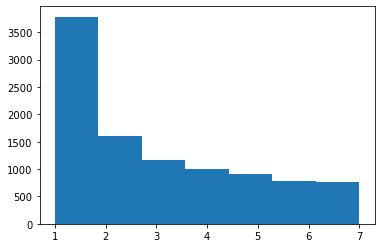

In [4]:
import matplotlib.pyplot as plt
import numpy as np

low, high = 1, 7
exponent = 2
sample = np.random.rand(10000)
#sample = np.random.pareto(a=exponent, size=10000)
sample = sample ** exponent
sample = sample * (high - low + 1) + low
sample = sample.astype(int)
print(sample.min(), sample.max(), sample.mean(), np.median(sample))

plt.hist(sample, bins=(high - low + 1))
plt.show()